In [1]:
#import yolo
#from yolo import YOLO

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

import torch
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from sklearn import metrics
import random

import sklearn.decomposition
import sklearn.manifold

# Use GPU if available
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0) # Set to your desired GPU number

from plotting_utils import plot_grid_search_losses, plot_map_hist, plot_map_hist_s, plot_multiplearch_losses

module_path = os.path.abspath(os.path.join('..'))
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)

#import data_preprocessing.visualization_utils as visutils
from model.constants import DATA_PATH, DATASETS_MAPPING, MODELS_PATH, NB_EPOCHS, BATCH_SIZE, PATIENCE, OPTIMIZER, TRAINING_IOU_THRESHOLD, CONF_THRESHOLD, NB_CONF_THRESHOLDS, NMS_IOU_THRESHOLD


Ultralytics YOLOv8.1.0 🚀 Python-3.11.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
Setup complete ✅ (36 CPUs, 376.6 GB RAM, 0.2/188.3 GB disk)
/vast/palmer/home.grace/eec42/BirdDetector/src


In [2]:
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0) # Set to your desired GPU number

print(device)

0


In [3]:
pretrained_model_name = 'YOLO_pe_10percent_background' #'YOLO_pe_10percent_background' #'DAN_pe_palmyra_10percentbkgd_dcgain1.5'
model_path = '/home/eec42/BirdDetector/runs/detect_supervised_gainsearch/' + pretrained_model_name + '/weights/last.pt'
model = YOLO(model_path, task='detect')

In [4]:

selected_img = []
img_path = '/gpfs/gibbs/project/jetz/eec42/data/pe_palmyra_10percentbkgd/test/'
selected_img.extend(random.choices(os.listdir(img_path + '/images/'), k=10))
#selected_img = os.listdir(img_path + '/images/')

# Predict results for randomly selected images
results = model.predict(
        #model = 'runs/detect/pfeifer_yolov8n_70epoch_default_batch32_dropout0.3',
        source = [os.path.join(img_path + 'images/', img) for img in selected_img],
        conf = 0.1, 
        iou = 0.1,
        show = False,
        save = False,
        visualize=True
    )


Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage0_Conv_features.png... (32/48)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage1_Conv_features.png... (32/96)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage2_C2f_features.png... (32/96)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage3_Conv_features.png... (32/192)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage4_C2f_features.png... (32/192)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage5_Conv_features.png... (32/384)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_760.0_640_640/stage6_C2f_features.png... (32/384)
Saving runs/detect/predict/global_birds_palmyra_Dudley_projected_593_patch_760.0_

In [ ]:


features_path = '/home/eec42/BirdDetector/runs/detect_supervised_gainsearch/YOLO_pe_10percent_background/features.pt'
features = torch.load(features_path)

print(len(features), features[0].size())
C = features[0].size()[0]
feats = []

for i in range(len(features)):
    reshaped_tensor = features[0].reshape(C, -1)
    concatenated_tensor = torch.cat([reshaped_tensor[i] for i in range(C)], dim=0).cpu()
    feats.append(concatenated_tensor)

feats_target = torch.stack(feats)

In [17]:
reduced_features = sklearn.decomposition.PCA(n_components=2, svd_solver='arpack').fit_transform(feats_target.cpu().numpy())
#reduced_features = sklearn.manifold.TSNE(n_components=2).fit_transform(feats_target.cpu().numpy())
reduced_features

array([[ 0.00019393, -7.4851e-13],
       [ 0.00019393,  8.8978e-13],
       [ 0.00019393, -2.2893e-13],
       [ 0.00019393,  -4.901e-13],
       [ 0.00019393,  6.5785e-13],
       [ 0.00019393, -3.9992e-13],
       [ 0.00019393, -6.6091e-13],
       [ 0.00019393, -9.8176e-13],
       [ 0.00019393, -3.2738e-13],
       [ 0.00019393,  4.2314e-14],
       [ 0.00019393, -1.2702e-12],
       [ 0.00019393,   1.309e-12],
       [ 0.00019393,  9.4958e-13],
       [ 0.00019393, -7.5532e-13],
       [ 0.00019393, -8.8929e-13],
       [ 0.00019393,  1.8528e-12],
       [ 0.00019393,  2.2486e-12],
       [ 0.00019393,  -1.319e-12],
       [ 0.00019393,  3.8675e-13],
       [ 0.00019393, -2.6781e-12],
       [ 0.00019393,  8.4223e-13],
       [ 0.00019393, -9.1563e-13],
       [ 0.00019393,  2.9929e-12],
       [ 0.00019393,  1.7029e-12],
       [ 0.00019393,  -1.079e-12],
       [ 0.00019393, -3.3104e-13],
       [ 0.00019393,   -2.82e-14],
       [ 0.00019393,  6.1535e-13],
       [ 0.00019393,

In [18]:
len(reduced_features)

200

In [19]:
domain_indice = []
for img_i, img in enumerate(selected_img):
    domain_indice.append(1 if img.startswith('global_birds_palmyra') else 0)

In [20]:
source_sample = []
target_sample = []
for sample_i in range(len(reduced_features)):
    if domain_indice[sample_i] == 1:
        target_sample.append(reduced_features[sample_i])
    else:
        source_sample.append(reduced_features[sample_i])

source_sample = np.array(source_sample)
target_sample = np.array(target_sample)

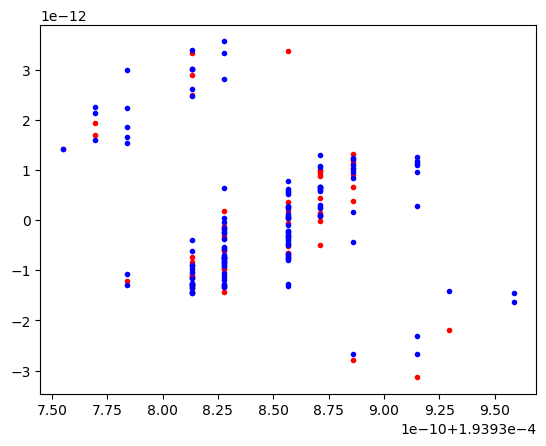

In [21]:
plt.plot(source_sample[:, 0], source_sample[:, 1], '.r')
plt.plot(target_sample[:, 0], target_sample[:, 1], '.b')

NameError: name 'tx' is not defined

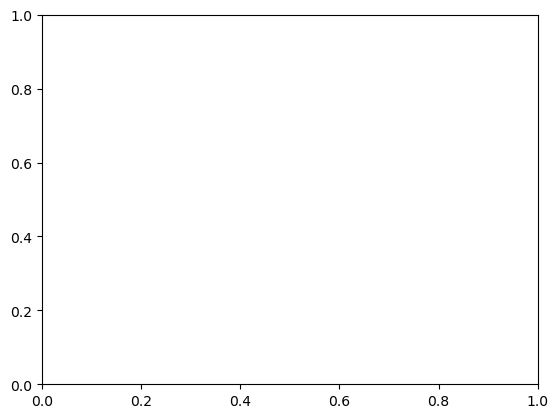

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
 
colors_per_class = {0:'blue', 1:'red'}

labels = []
for img in selected_img:
    labels.append(1 if os.path.basename(img).startswith('global_birds_palmyra') else 0)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors_per_class[label] #np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()